# Aplicação de Modelos de Markov e Redes Neurais LSTM na Previsão de Arrecadação do ICMS Paulista
## Resultados 2019

### Antonio Sergio Ferreira Bonato

Atualmente, na Secretaria da Fazenda e Planejamento do Estado de São Paulo, a previsão de arrecadação do ICMS paulista é feita usando-se um modelo ARIMA com variáveis exógenas, o ARIMAX. Mas o ICMS é não linear e há várias quebras estruturais controladas com diversas *dummies*. A consequência é um modelo bastante sobreajustado, inadequado para previsões de mais longo prazo (mais do que alguns meses, muito menos para um ano). 
A proposta deste trabalho é utilizar modelos não lineares multivariados na previsão do ICMS paulista, utilizando redes neurais recorrentes LSTM (*Long Short Term Memory*) e modelos Markov-Switching, fazendo um contraponto entre estes dois modelos. E utilizar, como baseline de comparação, o modelo ARIMAX atual. 

**Palavras-chave**: Markov-Switching Models. Redes Neurais Recorrentes. LSTM. ICMS.

## Treino das RNN-LSTM Multivariadas

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.tsa.stattools
import statsmodels.tsa.x13
import statsmodels.graphics.tsaplots
import statsmodels.api as sm
from statsmodels.graphics.api import qqplot
from statsmodels.tsa.api import acf, graphics, pacf
from statsmodels.tsa.arima.model import ARIMA
import pickle
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import random
import tensorflow as tf
seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

sns.set()
sns.set_context("notebook")
sns.set(rc={'figure.figsize':(15,8)})

In [2]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [3]:
df_main_orig = pd.read_excel("variaveis_previsao.xlsx", parse_dates=['date'])
df_main_orig.head()

,date,icms_sp,igp_m,dolar,ibc_br,dias_uteis,igp_m_22,dolar_22,ibc_br_22,igp_m_21,...,ibc_br_16,igp_m_15,dolar_15,ibc_br_15,igp_m_14,dolar_14,ibc_br_14,igp_m_13,dolar_13,ibc_br_13
0,2003-01-01,3.360296e+09,277.173,3.4384,96.15,22,277.173,3.4384,96.15,277.173,...,96.15,277.173,3.4384,96.15,277.173,3.4384,96.15,277.173,3.4384,96.15
1,2003-02-01,3.196558e+09,283.506,3.5908,98.67,20,283.506,3.5908,98.67,283.506,...,98.67,283.506,3.5908,98.67,283.506,3.5908,98.67,283.506,3.5908,98.67
2,2003-03-01,3.160011e+09,287.855,3.4469,103.41,19,287.855,3.4469,103.41,287.855,...,103.41,287.855,3.4469,103.41,287.855,3.4469,103.41,287.855,3.4469,103.41
3,2003-04-01,3.215307e+09,290.512,3.1187,102.19,20,290.512,3.1187,102.19,290.512,...,102.19,290.512,3.1187,102.19,290.512,3.1187,102.19,290.512,3.1187,102.19
4,2003-05-01,3.098930e+09,289.747,2.9557,100.30,21,289.747,2.9557,100.30,289.747,...,100.30,289.747,2.9557,100.30,289.747,2.9557,100.30,289.747,2.9557,100.30


In [4]:
df_main_orig.tail()

,date,icms_sp,igp_m,dolar,ibc_br,dias_uteis,igp_m_22,dolar_22,ibc_br_22,igp_m_21,...,ibc_br_16,igp_m_15,dolar_15,ibc_br_15,igp_m_14,dolar_14,ibc_br_14,igp_m_13,dolar_13,ibc_br_13
235,2022-08-01,1.756224e+10,1185.004,5.143287,149.60,23,1137.167829,5.6496,146.408337,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
236,2022-09-01,1.726287e+10,1173.793,5.236957,144.44,21,1143.597376,5.6800,142.808302,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
237,2022-10-01,1.565000e+10,1162.391,5.250300,142.34,20,1150.115881,5.6700,144.063428,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
238,2022-11-01,1.605000e+10,1155.829,5.274650,140.80,20,1155.866460,5.6000,143.165409,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
239,2022-12-01,1.767135e+10,1161.006,5.242432,142.78,22,1161.645792,5.6000,141.405133,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
df_main_orig.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 36 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        240 non-null    datetime64[ns]
 1   icms_sp     240 non-null    float64       
 2   igp_m       240 non-null    float64       
 3   dolar       240 non-null    float64       
 4   ibc_br      240 non-null    float64       
 5   dias_uteis  240 non-null    int64         
 6   igp_m_22    240 non-null    float64       
 7   dolar_22    240 non-null    float64       
 8   ibc_br_22   240 non-null    float64       
 9   igp_m_21    228 non-null    float64       
 10  dolar_21    228 non-null    float64       
 11  ibc_br_21   228 non-null    float64       
 12  igp_m_20    216 non-null    float64       
 13  dolar_20    216 non-null    float64       
 14  ibc_br_20   216 non-null    float64       
 15  igp_m_19    204 non-null    float64       
 16  dolar_19    204 non-null  

Removendo as últimas linhas que são todas NaN

In [6]:
df_main = df_main_orig.iloc[0:204]
datas = df_main['date']

In [7]:
df_main.tail()

,date,icms_sp,igp_m,dolar,ibc_br,dias_uteis,igp_m_22,dolar_22,ibc_br_22,igp_m_21,...,ibc_br_16,igp_m_15,dolar_15,ibc_br_15,igp_m_14,dolar_14,ibc_br_14,igp_m_13,dolar_13,ibc_br_13
199,2019-08-01,1.178403e+10,736.402,4.019982,141.95,22,736.402,4.019982,141.95,736.402,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
200,2019-09-01,1.214739e+10,736.362,4.121500,138.33,21,736.362,4.121500,138.33,736.362,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
201,2019-10-01,1.251718e+10,741.333,4.086987,142.94,23,741.333,4.086987,142.94,741.333,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
202,2019-11-01,1.257453e+10,743.558,4.155345,138.88,20,743.558,4.155345,138.88,743.558,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
203,2019-12-01,1.314626e+10,759.112,4.109590,137.43,21,759.112,4.109590,137.43,759.112,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Criação das Séries
Como os valores do ICMS são muito elevados a série será colocada em log.

In [8]:
icms_ts = pd.Series(np.log(list(df_main['icms_sp'])), index = datas)
ibcbr_ts = pd.Series(list(df_main['ibc_br']), index = datas)
igpm_ts = pd.Series(list(df_main['igp_m']), index = datas)
dolar_ts = pd.Series(list(df_main['dolar']), index = datas)
dias_uteis_ts = pd.Series(list(df_main['dias_uteis']), index = datas)

#### Testes de Valores Nulos

In [9]:
print('ICMS', icms_ts.isnull().sum())
print('IBC-Br', ibcbr_ts.isnull().sum())
print('IGP-DI', igpm_ts.isnull().sum())
print('Dólar', dolar_ts.isnull().sum())
print('Dias Úteis', dias_uteis_ts.isnull().sum())

ICMS 0
IBC-Br 0
IGP-DI 0
Dólar 0
Dias Úteis 0


### Plotando a Série em Nível

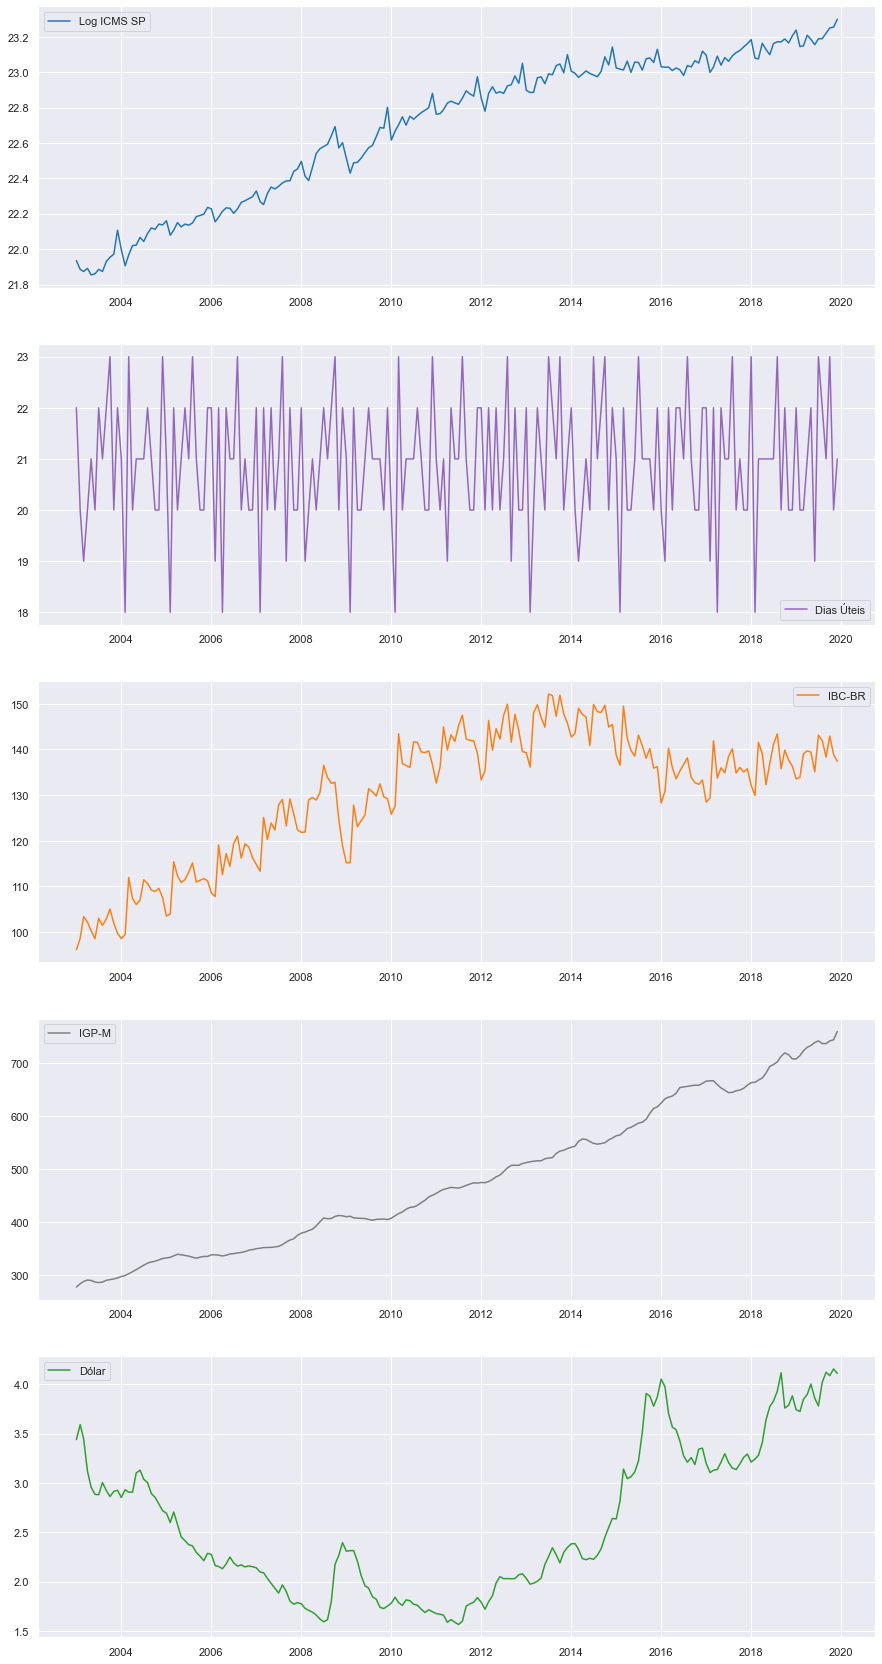

In [10]:
fig=plt.figure(figsize=(15, 30))
ax1=fig.add_subplot(511)
ax2=fig.add_subplot(512)
ax3=fig.add_subplot(513)
ax4=fig.add_subplot(514)
ax5=fig.add_subplot(515)
#plots
ax1.plot(icms_ts, 'tab:blue', label='Log ICMS SP')
ax1.legend(loc='best')
ax2.plot(dias_uteis_ts, 'tab:purple', label='Dias Úteis')
ax2.legend(loc='best')
ax3.plot(ibcbr_ts, 'tab:orange',  label='IBC-BR')
ax3.legend(loc='best')
ax4.plot(igpm_ts, 'tab:gray', label='IGP-M')
ax4.legend(loc='best')
ax5.plot(dolar_ts, 'tab:green', label='Dólar')
ax5.legend(loc='best')
plt.show()

## Preparação para Previsões

O artigo usa, além de MAPE e MSE, o erro relativo, que é 

$Erro Relativo = \frac{|previsão - real|}{real}$

In [11]:
def erro_relativo(prev, real):
    return 100*np.absolute(prev-real)/real

#### Dicionário de Previsões

In [12]:
previsoes = {
    'nome':[],
    'modelo': [],
    'previsoes': [],
    'rmse': [],
    'mape': [],
    'erro relativo':[]
}

### Separando a amostra em treinamento (in-sample) e teste (out-of-sample)
Serão usadas as séries com sazonalidade e em nível e as questões de sazonalidade e estacionariedade serão tratadas pelo modelo.

In [13]:
exog_df = pd.DataFrame((ibcbr_ts, igpm_ts,
                        dolar_ts, dias_uteis_ts
                       ), 
                        index=['ibcbr', 'igpdi', 'dolar', 'dias_uteis'
                            ]).transpose()
exog_df.head() 

,ibcbr,igpdi,dolar,dias_uteis
date,,,,
2003-01-01,96.15,277.173,3.4384,22.0
2003-02-01,98.67,283.506,3.5908,20.0
2003-03-01,103.41,287.855,3.4469,19.0
2003-04-01,102.19,290.512,3.1187,20.0
2003-05-01,100.30,289.747,2.9557,21.0


In [14]:
exog_df.tail() 

,ibcbr,igpdi,dolar,dias_uteis
date,,,,
2019-08-01,141.95,736.402,4.019982,22.0
2019-09-01,138.33,736.362,4.121500,21.0
2019-10-01,142.94,741.333,4.086987,23.0
2019-11-01,138.88,743.558,4.155345,20.0
2019-12-01,137.43,759.112,4.109590,21.0


In [15]:
exog = exog_df[:].to_numpy()
exog_train = exog[:-24]
exog_val = exog[-24:-12]
exog_test = exog[-12:]
print(exog.shape, exog_train.shape, exog_val.shape, exog_test.shape)

(204, 4) (180, 4) (12, 4) (12, 4)


In [16]:
icms_train = icms_ts[:-24]
icms_val = np.exp(icms_ts[-24:-12]) # série sem log
icms_test = np.exp(icms_ts[-12:]) # série sem log
print(icms_ts.shape, icms_train.shape, icms_val.shape, icms_test.shape)

(204,) (180,) (12,) (12,)


In [17]:
print('#'*30+'\n',icms_train)
print('#'*30+'\n',icms_val)
print('#'*30+'\n',icms_test)

##############################
 date
2003-01-01    21.935295
2003-02-01    21.885340
2003-03-01    21.873841
2003-04-01    21.891189
2003-05-01    21.854323
                ...    
2017-08-01    23.092037
2017-09-01    23.111282
2017-10-01    23.122725
2017-11-01    23.142988
2017-12-01    23.161246
Length: 180, dtype: float64
##############################
 date
2018-01-01    1.171836e+10
2018-02-01    1.055555e+10
2018-03-01    1.051107e+10
2018-04-01    1.147597e+10
2018-05-01    1.108135e+10
2018-06-01    1.076198e+10
2018-07-01    1.146222e+10
2018-08-01    1.157415e+10
2018-09-01    1.157068e+10
2018-10-01    1.176202e+10
2018-11-01    1.150136e+10
2018-12-01    1.196787e+10
dtype: float64
##############################
 date
2019-01-01    1.236685e+10
2019-02-01    1.126598e+10
2019-03-01    1.131000e+10
2019-04-01    1.201696e+10
2019-05-01    1.173362e+10
2019-06-01    1.138744e+10
2019-07-01    1.177099e+10
2019-08-01    1.178403e+10
2019-09-01    1.214739e+10
2019-10-01    1

## Modelos RNN LSTM
Redes Neurais Recorrentes com neurônios Long Short-Term Memory

### Montagem da Série com as Variáveis Exógenas
As redes neurais precisam de conjuntos de características e de etiquetas separados. As variáveis exógenas serão o conjunto de características e a variável endógena será o conjunto de etiquetas.

In [18]:
X_data = np.append(exog, np.roll(exog, 1, axis = 0), axis = 1)
X_data = np.append(X_data, np.roll(exog, 2, axis = 0), axis = 1)[2:]
Y_data = icms_ts[2:].to_numpy()

In [19]:
X_data.shape, Y_data.shape

((202, 12), (202,))

#### Normalização dos Dados
Serão normalizados usando-se min-max. Apenas as features, a variável target não será normalizada. Os dados serão dividos em treno, validação e teste para a normalização, de modo que o fit seja feito somente nos dados de treino, aumentando-se assim a probabilidade de generalização do modelo.

In [20]:
X_train = X_data[:-24]
X_val = X_data[-24:-12]
X_test = X_data[-12:]
print(X_train.shape, X_val.shape, X_test.shape)
Y_train = Y_data[:-24]
Y_val = Y_data[-24:-12]
Y_test = np.exp(Y_data[-12:]) # tirando o log
print(Y_train.shape, Y_val.shape, Y_test.shape)

(178, 12) (12, 12) (12, 12)
(178,) (12,) (12,)


In [21]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
# índice dos atributos numéricos
num_atrib = list(range(X_train.shape[1]))
print('numéricas', num_atrib)

enc_x = ColumnTransformer([('min-max',MinMaxScaler(), num_atrib)], verbose=True)

print(enc_x)
X_train_std = enc_x.fit_transform(X_train)
X_val_std = enc_x.transform(X_val)
X_test_std = enc_x.transform(X_test)

print(X_train_std.shape)
print(X_val_std.shape)
print(X_test_std.shape)

numéricas [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
ColumnTransformer(transformers=[('min-max', MinMaxScaler(),
                                 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])],
                  verbose=True)
[ColumnTransformer] ....... (1 of 1) Processing min-max, total=   0.0s
(178, 12)
(12, 12)
(12, 12)


In [22]:
x_train = X_train_std.reshape(X_train_std.shape[0], X_train_std.shape[1], 1)
x_val = X_val_std.reshape(X_val_std.shape[0], X_val_std.shape[1], 1)
x_test = X_test_std.reshape(X_test_std.shape[0], X_test_std.shape[1], 1)
print(x_train.shape, x_val.shape, x_test.shape)

y_train = Y_train.reshape(Y_train.shape[0], 1)
y_val = Y_val.reshape(Y_val.shape[0], 1)
y_test = Y_test.reshape(Y_test.shape[0], 1)
print(y_train.shape, y_val.shape, y_test.shape)

(178, 12, 1) (12, 12, 1) (12, 12, 1)
(178, 1) (12, 1) (12, 1)


### Criando o modelo LSTM

In [23]:
# importando as bibliotecas do Keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Conv1D, MaxPooling1D
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam

## Arquitetura da Rede - Camadas

In [24]:
rlrop = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=25)
early_stop = EarlyStopping(monitor='val_loss', patience=100, verbose=1, 
                           restore_best_weights=True)

In [25]:
# Épocas
EPOCHS = 1000
NEURONIOS = 600
DROPOUT = 0.15
LR = 1e-5
BATCH = 8

# Imstanciação do modelo
model = Sequential()

# Adicionar camada LSTM 
model.add(LSTM(activation='tanh', dropout=DROPOUT,
        input_shape = (12, 1), return_sequences = True,
        units = NEURONIOS))

# Adicionar camada LSTM 
model.add(LSTM(activation='tanh', dropout=DROPOUT,
        input_shape = (12, 1), return_sequences = True,
        units = NEURONIOS))

# Adicionar camada LSTM 
model.add(LSTM(activation='tanh', dropout=DROPOUT,
        input_shape = (12, 1), return_sequences = False,
        units = NEURONIOS))

# Adicionar a camada de saída com 1 neurônio linear
model.add(Dense(
        units = 1,
        activation = 'linear'))
# a learning rate padrão do Adam é 0.001
model.compile(loss = 'mape', optimizer = Adam(learning_rate=LR))

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 12, 600)           1444800   
_________________________________________________________________
lstm_1 (LSTM)                (None, 12, 600)           2882400   
_________________________________________________________________
lstm_2 (LSTM)                (None, 600)               2882400   
_________________________________________________________________
dense (Dense)                (None, 1)                 601       
Total params: 7,210,201
Trainable params: 7,210,201
Non-trainable params: 0
_________________________________________________________________


In [27]:
# History object for plotting our model loss by epoch
history = model.fit(x_train, y_train, batch_size = BATCH, 
                    epochs = EPOCHS, validation_data = (x_val, y_val),
                    callbacks = [rlrop, early_stop])

Epoch 1/1000
23/23 [==============================] - 3s 148ms/step - loss: 99.8463 - val_loss: 99.4763
Epoch 2/1000
23/23 [==============================] - 3s 114ms/step - loss: 99.4419 - val_loss: 98.6556
Epoch 3/1000
23/23 [==============================] - 2s 107ms/step - loss: 98.6577 - val_loss: 96.7633
Epoch 4/1000
23/23 [==============================] - 2s 108ms/step - loss: 96.6009 - val_loss: 91.2092
Epoch 5/1000
23/23 [==============================] - 2s 106ms/step - loss: 90.1161 - val_loss: 69.8458
Epoch 6/1000
23/23 [==============================] - 3s 113ms/step - loss: 64.7828 - val_loss: 19.6053
Epoch 7/1000
23/23 [==============================] - 3s 116ms/step - loss: 19.8776 - val_loss: 4.6607
Epoch 8/1000
23/23 [==============================] - 3s 114ms/step - loss: 4.9667 - val_loss: 4.8578
Epoch 9/1000
23/23 [==============================] - 3s 116ms/step - loss: 3.1301 - val_loss: 0.6981
Epoch 10/1000
23/23 [==============================] - 3s 124ms/step 

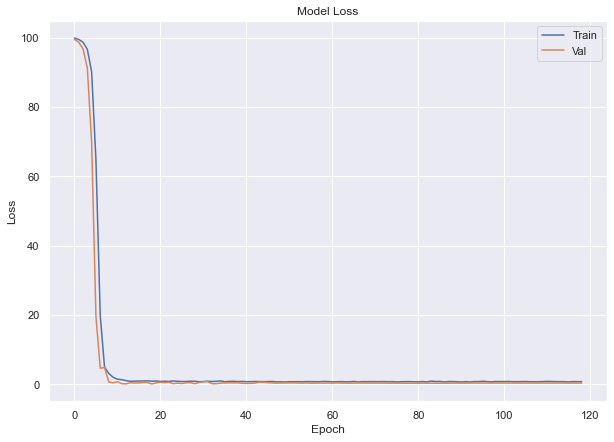

In [28]:
# Loss History
fig = plt.figure(figsize=(10, 7))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

### Previsão 12 meses em Validação

In [29]:
Y_pred_val = np.exp(model.predict(x_val))
Y_pred_val

array([[1.1060690e+10],
       [1.0469394e+10],
       [1.0972292e+10],
       [1.1128809e+10],
       [1.1119770e+10],
       [1.1258446e+10],
       [1.1406441e+10],
       [1.1709789e+10],
       [1.1473406e+10],
       [1.1558101e+10],
       [1.1364029e+10],
       [1.1279466e+10]], dtype=float32)

In [30]:
y_pred_val = pd.Series(Y_pred_val.ravel())
y_pred_val.index = icms_val.index
y_pred_val

date
2018-01-01    1.106069e+10
2018-02-01    1.046939e+10
2018-03-01    1.097229e+10
2018-04-01    1.112881e+10
2018-05-01    1.111977e+10
2018-06-01    1.125845e+10
2018-07-01    1.140644e+10
2018-08-01    1.170979e+10
2018-09-01    1.147341e+10
2018-10-01    1.155810e+10
2018-11-01    1.136403e+10
2018-12-01    1.127947e+10
dtype: float32

In [31]:
np.exp(y_val).ravel()

array([1.17183556e+10, 1.05555509e+10, 1.05110716e+10, 1.14759654e+10,
       1.10813459e+10, 1.07619813e+10, 1.14622162e+10, 1.15741454e+10,
       1.15706768e+10, 1.17620246e+10, 1.15013565e+10, 1.19678670e+10])

In [32]:
RMSE_lstm_val = mean_squared_error(np.exp(y_val).ravel(), y_pred_val, squared=False)
RMSE_lstm_val

363599205.6415559

In [33]:
MAPE_lstm_val = mean_absolute_percentage_error(np.exp(y_val).ravel(), y_pred_val)
MAPE_lstm_val

0.02498369017704065

In [34]:
previsoes['nome'].append('RNN-LSTM-Camadas')
previsoes['modelo'].append(model)
previsoes['previsoes'].append(y_pred_val)

previsoes['rmse'].append(RMSE_lstm_val)

previsoes['mape'].append(MAPE_lstm_val)

In [35]:
previsoes['erro relativo'].append([erro_relativo(prev,real) 
                                   for prev,real in zip(y_pred_val, y_test)])

## Arquitetura da Rede - Larga

In [36]:
rlrop2 = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=25)
early_stop2 = EarlyStopping(monitor='val_loss', patience=100, verbose=1, 
                           restore_best_weights=True)

In [37]:
# Épocas
EPOCHS2 = 1000
NEURONIOS2 = 600
DROPOUT2 = 0.15
LR2 = 1e-5
BATCH2 = 8

# Imstanciação do modelo
model2 = Sequential()

# Adicionar camada LSTM 
model2.add(LSTM(activation='tanh', dropout=DROPOUT2,
        input_shape = (12, 1), return_sequences = False,
        units = NEURONIOS2))

# Adicionar a camada de saída com 1 neurônio linear
model2.add(Dense(
        units = 1,
        activation = 'linear'))
# a learning rate padrão do Adam é 0.001
model2.compile(loss = 'mape', optimizer = Adam(learning_rate=LR2))

In [38]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 600)               1444800   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 601       
Total params: 1,445,401
Trainable params: 1,445,401
Non-trainable params: 0
_________________________________________________________________


In [39]:
# History object for plotting our model loss by epoch
history2 = model2.fit(x_train, y_train, batch_size = BATCH2, 
                    epochs = EPOCHS2, validation_data = (x_val, y_val),
                    callbacks = [rlrop2, early_stop2])

Epoch 1/1000
23/23 [==============================] - 2s 86ms/step - loss: 99.9241 - val_loss: 99.6668
Epoch 2/1000
23/23 [==============================] - 1s 50ms/step - loss: 99.6615 - val_loss: 99.2584
Epoch 3/1000
23/23 [==============================] - 1s 53ms/step - loss: 99.3946 - val_loss: 98.7870
Epoch 4/1000
23/23 [==============================] - 1s 56ms/step - loss: 99.0474 - val_loss: 98.2035
Epoch 5/1000
23/23 [==============================] - 1s 53ms/step - loss: 98.6525 - val_loss: 97.4226
Epoch 6/1000
23/23 [==============================] - 1s 55ms/step - loss: 98.0421 - val_loss: 96.2673
Epoch 7/1000
23/23 [==============================] - 1s 58ms/step - loss: 97.2050 - val_loss: 94.4129
Epoch 8/1000
23/23 [==============================] - 1s 55ms/step - loss: 95.6579 - val_loss: 90.9046
Epoch 9/1000
23/23 [==============================] - 1s 51ms/step - loss: 92.7007 - val_loss: 82.9945
Epoch 10/1000
23/23 [==============================] - 1s 53ms/step - los

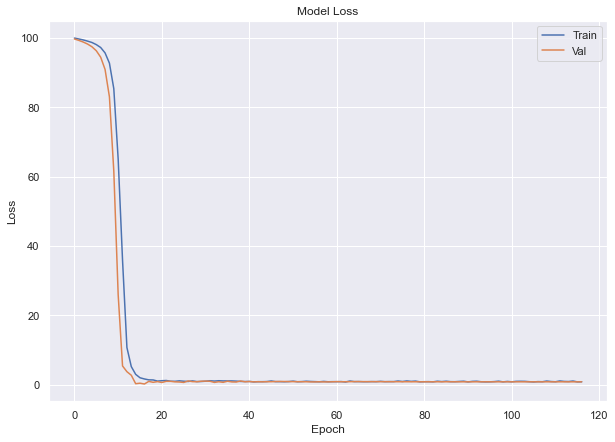

In [40]:
# Loss History
fig = plt.figure(figsize=(10, 7))
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

### Previsão 12 meses em Validação

In [41]:
Y_pred_val2 = np.exp(model2.predict(x_val))
Y_pred_val2

array([[1.0753585e+10],
       [1.0285204e+10],
       [1.0827471e+10],
       [1.0864480e+10],
       [1.0722679e+10],
       [1.0824250e+10],
       [1.0893739e+10],
       [1.0964195e+10],
       [1.0790856e+10],
       [1.0862989e+10],
       [1.0799772e+10],
       [1.0786905e+10]], dtype=float32)

In [42]:
y_pred_val2 = pd.Series(Y_pred_val2.ravel())
y_pred_val2.index = icms_val.index
y_pred_val2

date
2018-01-01    1.075359e+10
2018-02-01    1.028520e+10
2018-03-01    1.082747e+10
2018-04-01    1.086448e+10
2018-05-01    1.072268e+10
2018-06-01    1.082425e+10
2018-07-01    1.089374e+10
2018-08-01    1.096420e+10
2018-09-01    1.079086e+10
2018-10-01    1.086299e+10
2018-11-01    1.079977e+10
2018-12-01    1.078691e+10
dtype: float32

In [43]:
np.exp(y_val).ravel()

array([1.17183556e+10, 1.05555509e+10, 1.05110716e+10, 1.14759654e+10,
       1.10813459e+10, 1.07619813e+10, 1.14622162e+10, 1.15741454e+10,
       1.15706768e+10, 1.17620246e+10, 1.15013565e+10, 1.19678670e+10])

In [44]:
RMSE_lstm_val2 = mean_squared_error(np.exp(y_val).ravel(), y_pred_val2, squared=False)
RMSE_lstm_val2

683672346.8174833

In [45]:
MAPE_lstm_val2 = mean_absolute_percentage_error(np.exp(y_val).ravel(), y_pred_val2)
MAPE_lstm_val2

0.05294038849574421

In [46]:
previsoes['nome'].append('RNN-LSTM-Larga')
previsoes['modelo'].append(model2)
previsoes['previsoes'].append(y_pred_val2)

previsoes['rmse'].append(RMSE_lstm_val2)

previsoes['mape'].append(MAPE_lstm_val2)

In [47]:
previsoes['erro relativo'].append([erro_relativo(prev,real) 
                                   for prev,real in zip(y_pred_val2, y_test)])

## Resultados

In [48]:
df_prev = pd.DataFrame(data=previsoes['previsoes'], 
                       index=previsoes['nome']).transpose()
df_prev["real"] = icms_val
df_rmse = pd.DataFrame(data=previsoes['rmse'], 
                       index=previsoes['nome']).transpose()
df_mape = pd.DataFrame(data=previsoes['mape'], 
                       index=previsoes['nome']).transpose()
df_erro = pd.DataFrame(data=previsoes['erro relativo'], 
                       index=previsoes['nome']).transpose()

In [49]:
df_prev

,RNN-LSTM-Camadas,RNN-LSTM-Larga,real
date,,,
2018-01-01,1.106069e+10,1.075359e+10,1.171836e+10
2018-02-01,1.046939e+10,1.028520e+10,1.055555e+10
2018-03-01,1.097229e+10,1.082747e+10,1.051107e+10
2018-04-01,1.112881e+10,1.086448e+10,1.147597e+10
2018-05-01,1.111977e+10,1.072268e+10,1.108135e+10
2018-06-01,1.125845e+10,1.082425e+10,1.076198e+10
2018-07-01,1.140644e+10,1.089374e+10,1.146222e+10
2018-08-01,1.170979e+10,1.096420e+10,1.157415e+10
2018-09-01,1.147341e+10,1.079086e+10,1.157068e+10


In [50]:
df_erro

,RNN-LSTM-Camadas,RNN-LSTM-Larga
0,[10.56177723091434],[13.04506759096381]
1,[7.070710770757266],[8.705632583446913]
2,[2.9859084370002575],[4.266379435294386]
3,[7.39079478307577],[9.590429763885036]
4,[5.23157131131273],[8.615784656796853]
5,[1.13280470897715],[4.945736583758334]
6,[3.0970204528578815],[7.452664279613089]
7,[0.6300253917082369],[6.957179653379558]
8,[5.548349703684825],[11.167256580187438]
9,[7.662075857280178],[13.215338423767928]


### Resultados

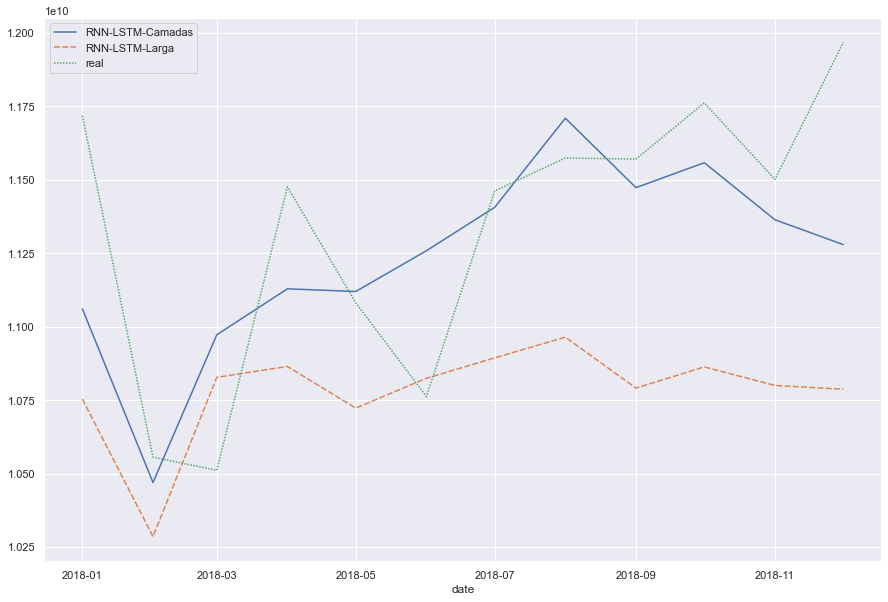

In [51]:
fig = plt.figure(figsize=(15, 10))
ax = sns.lineplot(data=df_prev)

#### RMSE

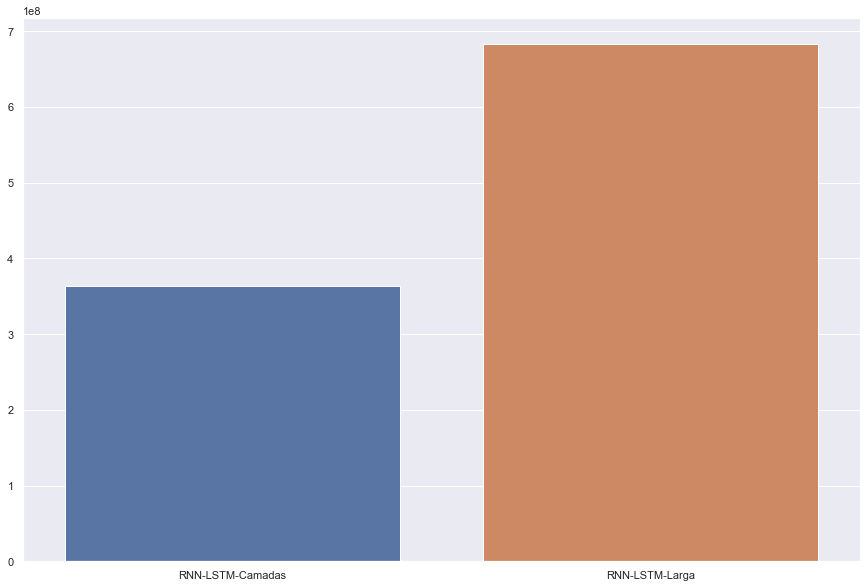

In [52]:
fig = plt.figure(figsize=(15, 10))
ax = sns.barplot(data=df_rmse)

#### MAPE

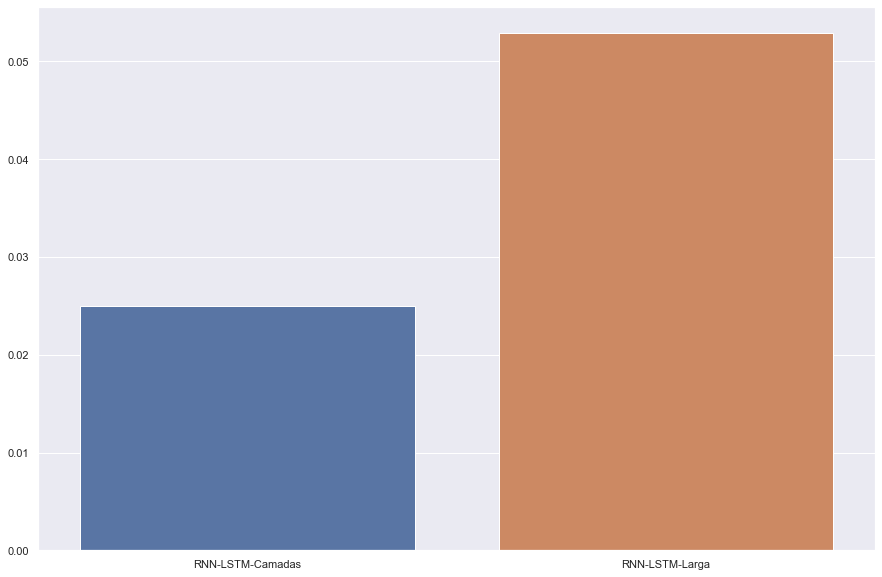

In [53]:
fig = plt.figure(figsize=(15, 10))
ax = sns.barplot(data=df_mape)

### Resumo das métricas

In [54]:
df_rmse.index = ['RMSE']
df_mape.index = ['MAPE']

In [55]:
df_metricas = df_rmse.copy()
df_metricas = df_metricas.append(df_mape)
df_metricas

,RNN-LSTM-Camadas,RNN-LSTM-Larga
RMSE,3.635992e+08,6.836723e+08
MAPE,2.498369e-02,5.294039e-02
